In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_onlychild = processed_data[processed_data['are_you_an_only_child'].isin([0, 1])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_onlychild['rating'] = df_onlychild['rating'].astype(str)


# only keep spcific columns
df_onlychild = df_onlychild[['movie_name', 'year', 'rating', 'are_you_an_only_child']]

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



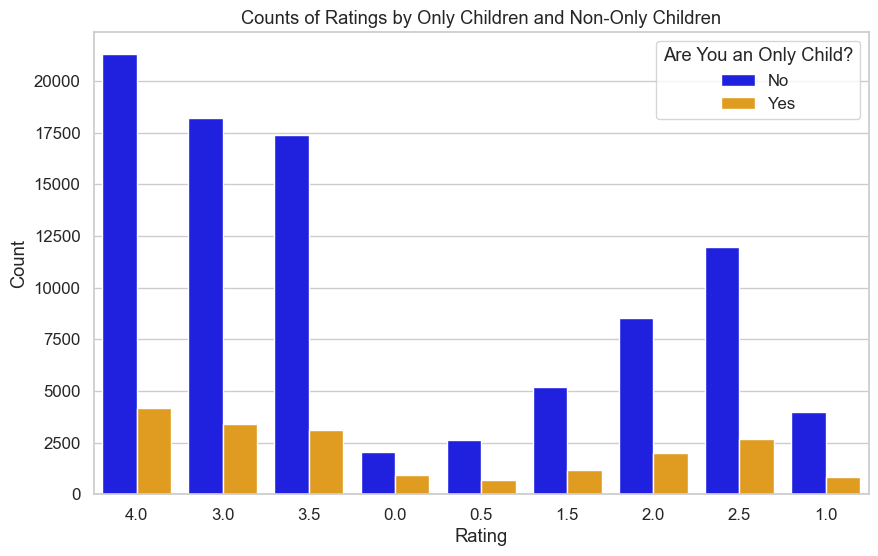

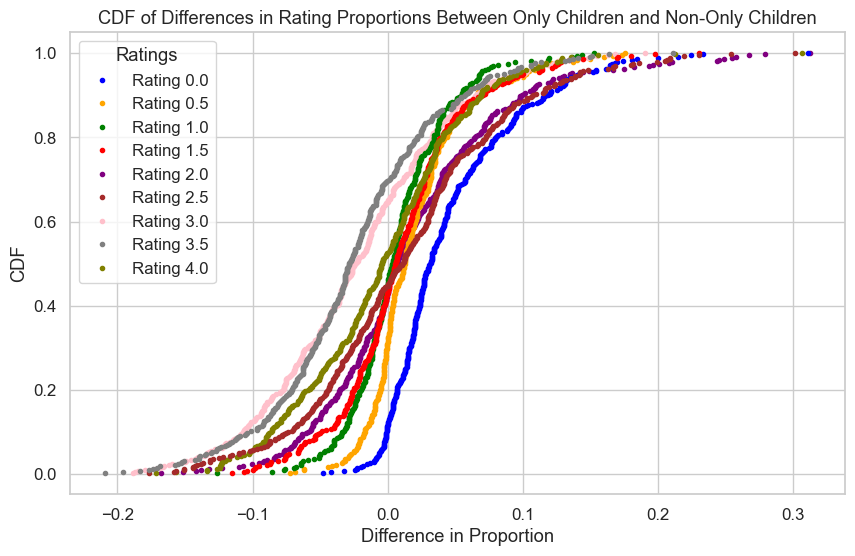

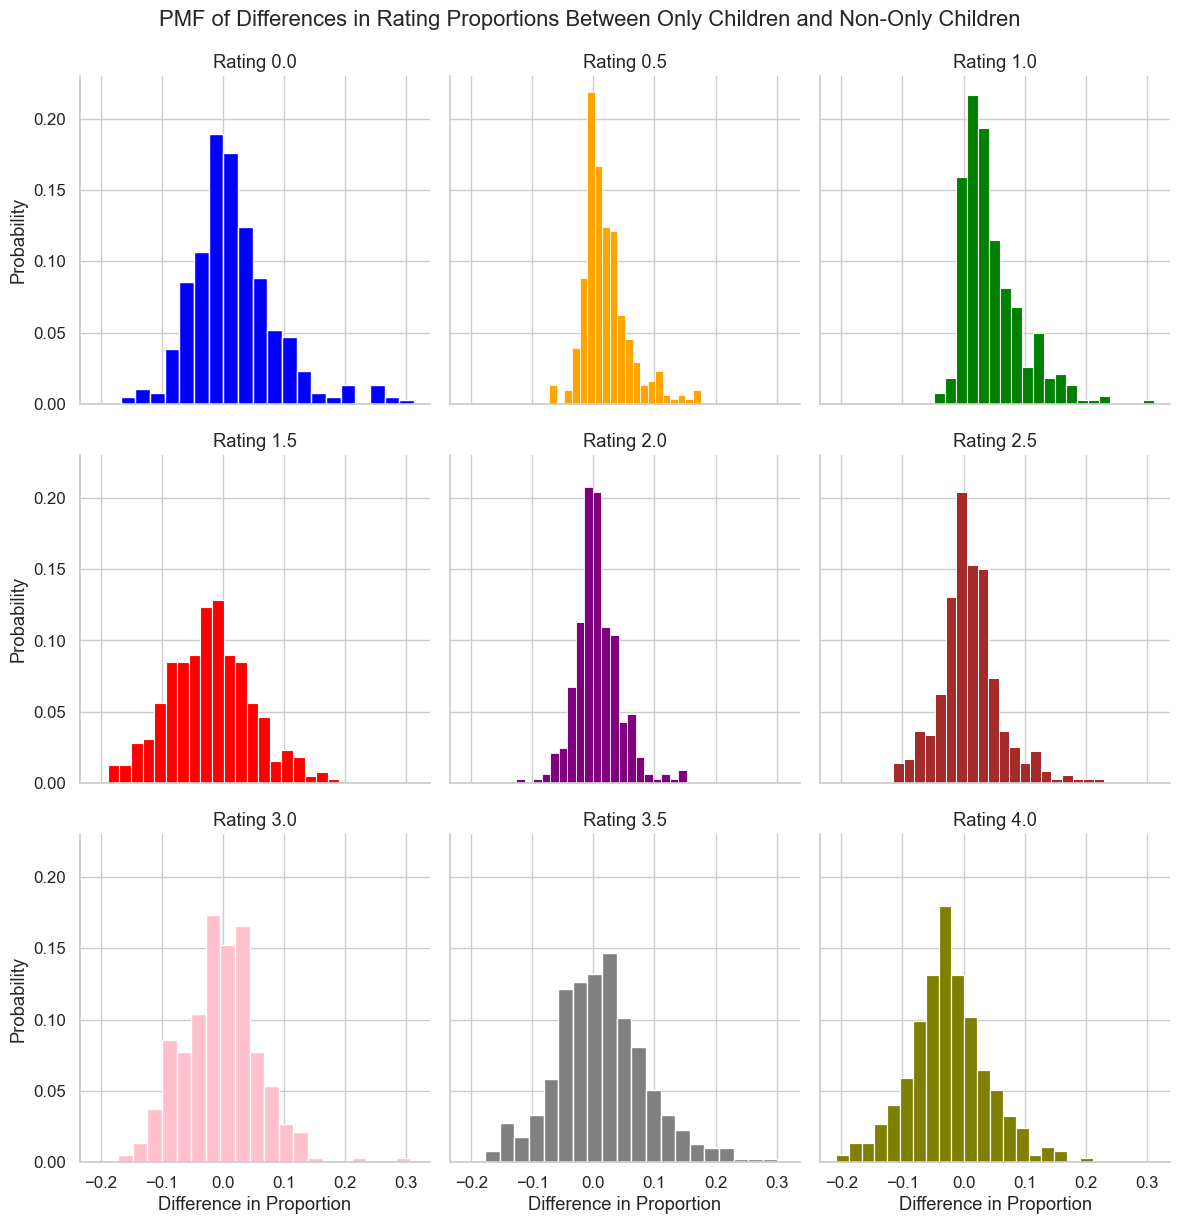

/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_17210/2109362030.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Ratings')


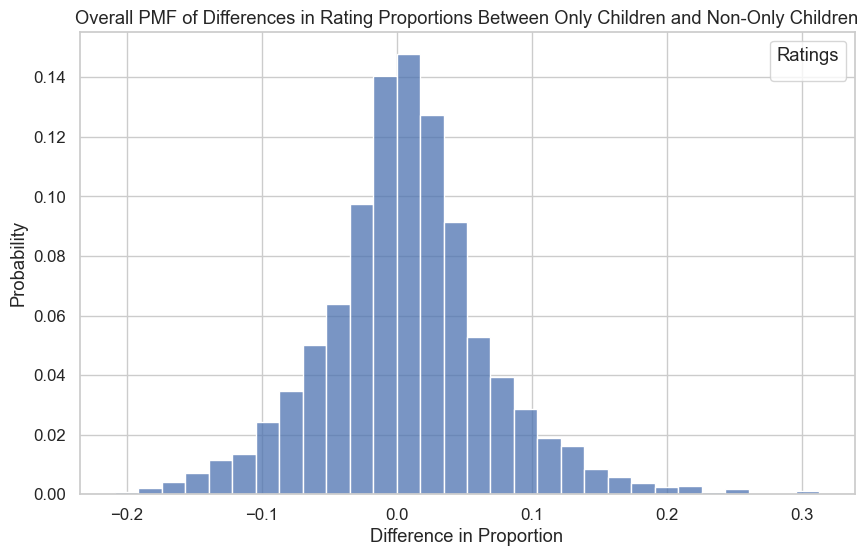

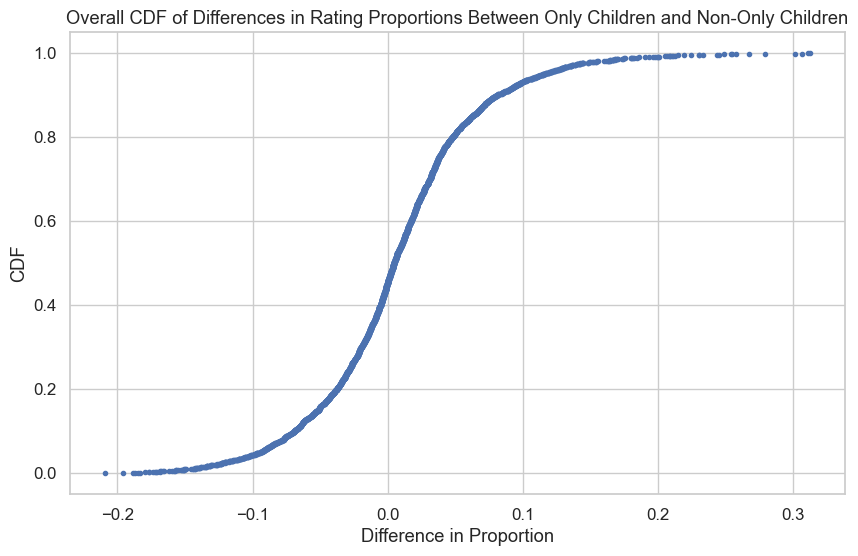

In [37]:
grouped = df_onlychild.groupby(['movie_name', 'year', 'are_you_an_only_child'])['rating'].value_counts(normalize=True).rename('proportion').reset_index()

# difference between only child and non-only child for each movie
only_child_group = grouped[grouped['are_you_an_only_child'] == 1]
non_only_child_group = grouped[grouped['are_you_an_only_child'] == 0]

merged = pd.merge(only_child_group, non_only_child_group, on=['movie_name', 'year', 'rating'], suffixes=('_only_child', '_non_only_child'))
merged['difference'] = merged['proportion_only_child'] - merged['proportion_non_only_child']
merged = merged.sort_values(by='difference', key=abs, ascending=True).drop(columns=['are_you_an_only_child_only_child', 'are_you_an_only_child_non_only_child'])


# color schema for each rating 
color_schema = {
    0: 'blue',
    0.5: 'orange',
    1: 'green',
    1.5: 'red',
    2: 'purple',
    2.5: 'brown',
    3: 'pink',
    3.5: 'gray',
    4: 'olive'
}

# plot the counts per rating for only children and non-only children
plt.figure(figsize=(10, 6))
sns.countplot(data=df_onlychild, x='rating', hue='are_you_an_only_child', palette=['blue', 'orange'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Counts of Ratings by Only Children and Non-Only Children')
plt.legend(title='Are You an Only Child?', labels=['No', 'Yes'])
plt.show()


# plot the differences for each rating
# CDF plot for the differences

plt.figure(figsize=(10, 6))
for rating in merged['rating'].unique():
    subset = merged[merged['rating'] == rating]
    sorted_diff = np.sort(subset['difference'])
    cdf = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff)
    plt.plot(sorted_diff, cdf, marker='.', linestyle='none', label=f'Rating {rating}')

plt.xlabel('Difference in Proportion')
plt.ylabel('CDF')

# order the legend by rating
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))

# set the colors according to the color schema
for i, label in enumerate(labels):
    rating_value = float(label.split()[-1])
    handles[i].set_color(color_schema.get(rating_value, 'black'))

plt.legend(handles, labels, title='Ratings')
plt.title('CDF of Differences in Rating Proportions Between Only Children and Non-Only Children')
plt.show()


# plot a PMF plot for the differences (sub-plots for each rating)
g = sns.FacetGrid(merged, col="rating", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, "difference", bins=20, stat="probability", kde=False)

# order by rating
for ax, rating in zip(g.axes.flat, sorted(merged['rating'].unique())):
    ax.set_title(f'Rating {rating}')
    rating_value = float(rating)
    for patch in ax.patches:
        patch.set_facecolor(color_schema.get(rating_value, 'black'))

g.set_axis_labels("Difference in Proportion", "Probability")
g.figure.suptitle('PMF of Differences in Rating Proportions Between Only Children and Non-Only Children', y=1.02)
plt.show()


# one plot for the overall distribution of differences
plt.figure(figsize=(10, 6))
sns.histplot(merged, x="difference", bins=30, stat="probability", kde=False, multiple="dodge")
plt.xlabel('Difference in Proportion')
plt.ylabel('Probability')
plt.title('Overall PMF of Differences in Rating Proportions Between Only Children and Non-Only Children')
plt.legend(title='Ratings')
plt.show()

# one overall CDF plot for the differences
plt.figure(figsize=(10, 6))
sorted_diff = np.sort(merged['difference'])
cdf = np.arange(1, len(sorted_diff) + 1) / len(sorted_diff)
plt.plot(sorted_diff, cdf, marker='.', linestyle='none')
plt.xlabel('Difference in Proportion')
plt.ylabel('CDF')
plt.title('Overall CDF of Differences in Rating Proportions Between Only Children and Non-Only Children')
plt.show()


In [ ]:
def total_variation_distance(p, q):
    p, q = np.asarray(p, dtype=float), np.asarray(q, dtype=float)
    p, q = p / p.sum(), q / q.sum()
    return 0.5 * np.sum(np.abs(p - q))


df_gender_movie = df_onlychild.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['chi_p_value', 'dof', 'expected', 'jvd', 'mw_p_value', 'mw_u_stat', 'ks_p_value', 'ks_stat'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()

    # Split ratings by only child status
    only_child_ratings = ratings[group['are_you_an_only_child'] == 1].astype(float)
    not_only_child_ratings = ratings[group['are_you_an_only_child'] == 0].astype(float)

    if len(only_child_ratings) > 0 and len(not_only_child_ratings) > 0:

        # check if ratings have na values
        if only_child_ratings.isna().sum() > 0 or not_only_child_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(only_child_ratings, not_only_child_ratings, alternative='two-sided')
        
        # x^2 test
        contingency_table = pd.crosstab(group['are_you_an_only_child'], group['rating'])
        chi2, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)
        
        # KS test
        ks_stat, p_value_ks = stats.ks_2samp(only_child_ratings, not_only_child_ratings)

        only_child = contingency_table.loc[1]
        not_only_child = contingency_table.loc[0]
        results.loc[movie_name] = [p_value_chi2, dof, expected, total_variation_distance(only_child, not_only_child), p_value_mw, u_stat, p_value_ks, ks_stat]

In [ ]:
# proportions of movies with significant differences
significant_chi2 = (results['chi_p_value'] < ALPHA).sum()
significant_mw = (results['mw_p_value'] < ALPHA).sum()
significant_ks = (results['ks_p_value'] < ALPHA).sum()

print(f"Number of movies with significant differences (Chi-squared test): {significant_chi2} out of {n_movies} = {significant_chi2 / n_movies:.2%}")
print(f"Number of movies with significant differences (Mann-Whitney U test): {significant_mw} out of {n_movies} = {significant_mw / n_movies:.2%}")
print(f"Number of movies with significant differences (KS test): {significant_ks} out of {n_movies} = {significant_ks / n_movies:.2%}")

Number of movies with significant differences (Chi-squared test): 7 out of 400 = 1.75%
Number of movies with significant differences (Mann-Whitney U test): 7 out of 400 = 1.75%
Number of movies with significant differences (KS test): 3 out of 400 = 0.75%
